# Simulation of graphene on QuEra

### TO DO:

#### general
- AWS access

#### problem-specific
- think of positive couplings
- periodic boudnary conditions
    - post-processing
    - "protective layer of atoms" (needs local fields)
    - scale up approach
- redefine the problem in terms of graph partitioning

In [1]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.field import Field
from braket.ahs.pattern import Pattern
from braket.ahs.shifting_field import ShiftingField

from braket.devices import LocalSimulator


from ahs_utils import show_drive_and_shift
from ahs_utils import show_register

import numpy as np

ModuleNotFoundError: No module named 'ahs_utils'

## Build the graphene supercell

In [20]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 2
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
structure = graphene_supercell
graphene_supercell.num_sites

8

In [21]:
from ase.visualize import view
from pymatgen.io.ase import AseAtomsAdaptor

In [22]:
view(AseAtomsAdaptor().get_atoms(graphene_supercell))

<Popen: returncode: None args: ['/Users/maolinml/opt/anaconda3/bin/python', ...>

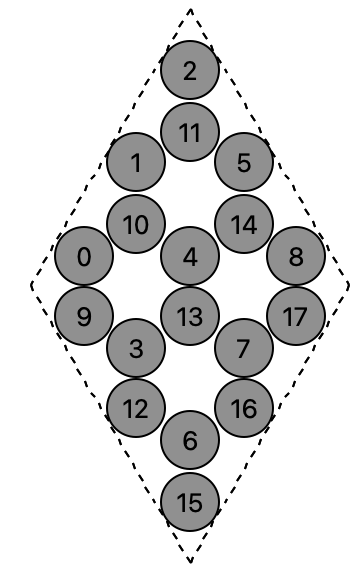

graphene_supercell is a pymatgen Structure object

## Build the adjacency matrix

In [5]:
import numpy as np
    
distance_matrix_pbc = np.round(structure.distance_matrix,5)

shells = np.unique(distance_matrix_pbc[0])

adjacency_matrix = np.round(distance_matrix_pbc,5) == np.round(shells[1],5)
adjacency_matrix = adjacency_matrix.astype(int)
adjacency_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1],
       [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,

## The initial QUBO matrix

The initial QUBO matrix is built using the following assumptions:
- each bond decreases the energy of the system by 1 arbitrary unit
- only nearest neighbours are included in this model
- if a an atom is next to a vacancy or if two vacancies are next to each other there is no bond

The top right part of adjacency_matrix (changed by sign) can be used.

In [13]:
Q = -np.triu(adjacency_matrix)
Q

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0, -1,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,
        -1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,
         0, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1, -1,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1, -1,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0, -1,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,
        -1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,
         0, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 0,  0,  0,  

## Calculating the energy classically using the QUBO matrix
The energy can be calculated by using:
$$
E(\textbf{x}) =  \textbf{x}^\textbf{T}\textbf{Qx} = 
    \sum_{i} Q_{i,i} x_{i} + \sum_{i} \sum_{j > i} Q_{i,j} x_{i}x_{j} \ \ \ \ \ x_{i} \in \{0,1\}
$$

In the $\textbf{x}$ vector, $x_i$= 1 corresponds to an atom in position $i$, $x_i$= 0 corresponds to a vacancy in position $i$

## 0 vacancy

In [17]:
x = np.array([1]*18)
Qx = np.matmul(x,Q)
E_0v = np.matmul(x,Qx)
E_0v

-27

## 1 vacancy

3 broken bonds

In [18]:
x = np.array([1]*18)
x[0] = 0
Qx = np.matmul(x,Q)
np.matmul(x,Qx)

-24

## 2 vacancies

Non-first neighbours (6 broken bonds)

In [19]:
x = np.array([1]*18)
x[0] = 0
x[1] = 0
Qx = np.matmul(x,Q)
np.matmul(x,Qx)

-21

First neighbours (5 broken bonds)

In [20]:
x = np.array([1]*18)
x[0] = 0
x[9] = 0
Qx = np.matmul(x,Q)
np.matmul(x,Qx)

-22

## Make interaction positive
Q_p = QUBO positive

In [35]:
Q_p = np.triu(adjacency_matrix)

In [33]:
x = np.array([1]*18)
Qx = np.matmul(x,Q_p)
np.matmul(x,Qx)

27

## 0 vacancy

In [34]:
x = np.array([1]*18)
Qx = np.matmul(x,Q_p)
E_0v = np.matmul(x,Qx)
E_0v

27

## 1 vacancy

3 broken bonds

In [26]:
x = np.array([0]*18)
x[0] = 1
Qx = np.matmul(x,Q_p)
np.matmul(x,Qx)

0

## 2 vacancies

Non-first neighbours (6 broken bonds)

In [19]:
x = np.array([1]*18)
x[0] = 0
x[1] = 0
Qx = np.matmul(x,Q)
np.matmul(x,Qx)

-21

# QUBO -> UDG-MWIS

From arXiv:2209.03965v2 section V.C and appendix C

#### QUBO to Ising

In [6]:
adjacency_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1],
       [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [8]:
Q = {}
ones = np.where(adjacency_matrix == 1)
for i in range(len(ones[0])):
    Q[(ones[0][i],ones[1][i])] = -1

In [11]:
from dimod.utilities import qubo_to_ising
qubo_to_ising(Q)

({0: -1.5,
  9: -1.5,
  10: -1.5,
  15: -1.5,
  1: -1.5,
  11: -1.5,
  16: -1.5,
  2: -1.5,
  17: -1.5,
  3: -1.5,
  12: -1.5,
  13: -1.5,
  4: -1.5,
  14: -1.5,
  5: -1.5,
  6: -1.5,
  7: -1.5,
  8: -1.5},
 {(0, 9): -0.25,
  (0, 10): -0.25,
  (0, 15): -0.25,
  (1, 10): -0.25,
  (1, 11): -0.25,
  (1, 16): -0.25,
  (2, 9): -0.25,
  (2, 11): -0.25,
  (2, 17): -0.25,
  (3, 9): -0.25,
  (3, 12): -0.25,
  (3, 13): -0.25,
  (4, 10): -0.25,
  (4, 13): -0.25,
  (4, 14): -0.25,
  (5, 11): -0.25,
  (5, 12): -0.25,
  (5, 14): -0.25,
  (6, 12): -0.25,
  (6, 15): -0.25,
  (6, 16): -0.25,
  (7, 13): -0.25,
  (7, 16): -0.25,
  (7, 17): -0.25,
  (8, 14): -0.25,
  (8, 15): -0.25,
  (8, 17): -0.25,
  (9, 0): -0.25,
  (9, 2): -0.25,
  (9, 3): -0.25,
  (10, 0): -0.25,
  (10, 1): -0.25,
  (10, 4): -0.25,
  (11, 1): -0.25,
  (11, 2): -0.25,
  (11, 5): -0.25,
  (12, 3): -0.25,
  (12, 5): -0.25,
  (12, 6): -0.25,
  (13, 3): -0.25,
  (13, 4): -0.25,
  (13, 7): -0.25,
  (14, 4): -0.25,
  (14, 5): -0.25,
  (14, 

## AFM edge
This is the basic unit for the AFM edge as reported in the paper

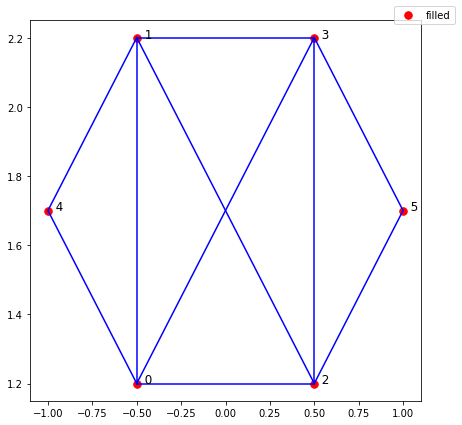

In [72]:
# Define H and register (2D atom arrangement)
register = AtomArrangement()
H = Hamiltonian()

ahs_program = AnalogHamiltonianSimulation(
    hamiltonian=H,
    register=register
)

# Build the register

# e.g. three atoms in an equilateral triangle, with pairwise
# separation equal to 5.5 micrometers
a = 5.5e-6  # meters
a = 1  # meters

coord = np.array([[-a/2, -a/2],[-a/2, a/2],[a/2, -a/2],[a/2,a/2],[-a,0],[a,0]])


r=1.7
radians = [(2*np.pi)/3,-(2*np.pi)/3]
coord_shift = coord+[0,r]
for xy in coord_shift:
    register.add(xy)
    

show_register(register,blockade_radius=1.5,what_to_draw="bond" )

## AFM edges in the "graphene ring" arrangement

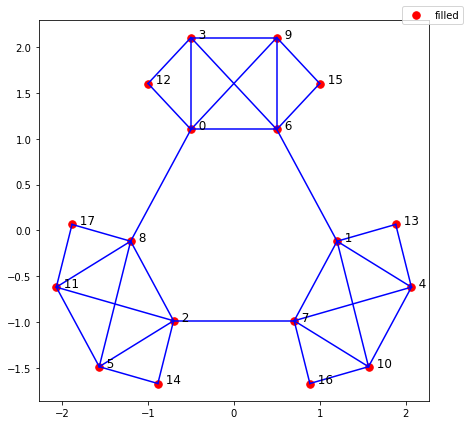

In [83]:
# Define H and register (2D atom arrangement)
register = AtomArrangement()
H = Hamiltonian()

ahs_program = AnalogHamiltonianSimulation(
    hamiltonian=H,
    register=register
)

# Build the register

# e.g. three atoms in an equilateral triangle, with pairwise
# separation equal to 5.5 micrometers
a = 5.5e-6  # meters
a = 1  # meters

coord = np.array([[-a/2, -a/2],[-a/2, a/2],[a/2, -a/2],[a/2,a/2],[-a,0],[a,0]])


coord = np.array([[-a/2, -a/2],[-a/2, a/2],[a/2, -a/2],[a/2,a/2],[-a,0],[a,0]])

r=1.6
radians = [(2*np.pi)/3,-(2*np.pi)/3]
coord_shift = coord+[0,r]
for xy in coord_shift:
    register.add(xy)
    for rad in radians:
        register.add(rotate_origin_only(xy, rad))

show_register(register,blockade_radius=1.5,what_to_draw="bond" )

## AFM edge with extra bits
This is the basic unit for the AFM edge as reported in the paper

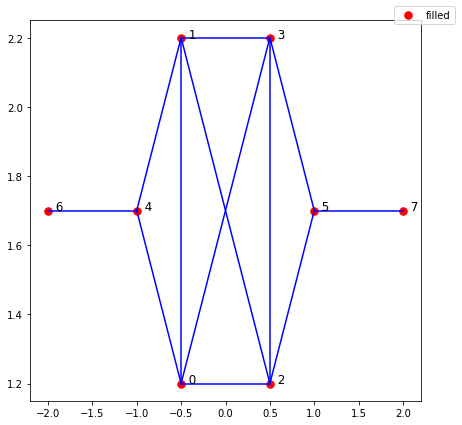

In [84]:
# Define H and register (2D atom arrangement)
register = AtomArrangement()
H = Hamiltonian()

ahs_program = AnalogHamiltonianSimulation(
    hamiltonian=H,
    register=register
)

# Build the register

# e.g. three atoms in an equilateral triangle, with pairwise
# separation equal to 5.5 micrometers
a = 5.5e-6  # meters
a = 1  # meters

coord = np.array([[-a/2, -a/2],[-a/2, a/2],[a/2, -a/2],[a/2,a/2],[-a,0],[a,0],[-2*a,0],[2*a,0]])


r=1.7
radians = [(2*np.pi)/3,-(2*np.pi)/3]
coord_shift = coord+[0,r]
for xy in coord_shift:
    register.add(xy)
    

show_register(register,blockade_radius=1.5,what_to_draw="bond" )

## AFM edges (extra bits) in the "graphene ring" arrangement

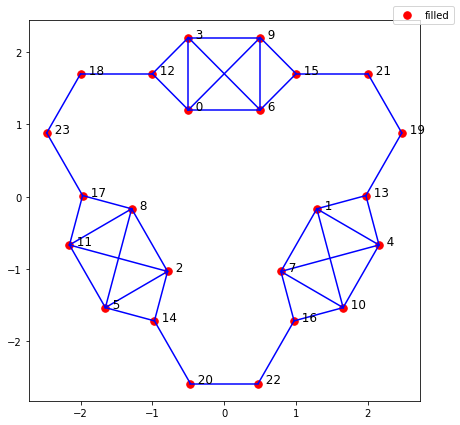

In [69]:
# Define H and register (2D atom arrangement)
register = AtomArrangement()
H = Hamiltonian()

ahs_program = AnalogHamiltonianSimulation(
    hamiltonian=H,
    register=register
)

# Build the register

# e.g. three atoms in an equilateral triangle, with pairwise
# separation equal to 5.5 micrometers
a = 5.5e-6  # meters
a = 1  # meters

coord = np.array([[-a/2, -a/2],[-a/2, a/2],[a/2, -a/2],[a/2,a/2],[-a,0],[a,0]])


coord = np.array([[-a/2, -a/2],[-a/2, a/2],[a/2, -a/2],[a/2,a/2],[-a,0],[a,0],[-2*a,0],[2*a,0]])

r=1.7
radians = [(2*np.pi)/3,-(2*np.pi)/3]
coord_shift = coord+[0,r]
for xy in coord_shift:
    register.add(xy)
    for rad in radians:
        register.add(rotate_origin_only(xy, rad))

show_register(register,blockade_radius=1.5,what_to_draw="bond" )

## AFM edges (extra bits) preparing for the full graphene structure 

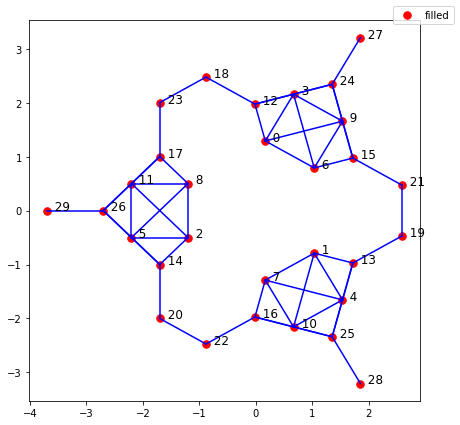

In [91]:
# Define H and register (2D atom arrangement)
register = AtomArrangement()
H = Hamiltonian()

ahs_program = AnalogHamiltonianSimulation(
    hamiltonian=H,
    register=register
)

# Build the register

# e.g. three atoms in an equilateral triangle, with pairwise
# separation equal to 5.5 micrometers
a = 5.5e-6  # meters
a = 1  # meters

coord = np.array([[-a/2, -a/2],[-a/2, a/2],[a/2, -a/2],[a/2,a/2],[-a,0],[a,0],[-2*a,0],[2*a,0],[0,a],[0,2*a]])

all_coord = []

origin_shift = (2*np.pi)/12

r=1.7
radians = [origin_shift,origin_shift+(2*np.pi)/3,origin_shift-(2*np.pi)/3]
coord_shift = coord+[0,r]
for xy in coord_shift:
    for rad in radians:
        all_coord.append(rotate_origin_only(xy, rad))
for xy in all_coord:
    register.add(xy)
show_register(register,blockade_radius=1.5,what_to_draw="bond" )

In [44]:
def rotate_origin_only(xy, radians):
    """Only rotate a point around the origin (0, 0)."""
    x, y = xy
    xx = x * np.math.cos(radians) + y * np.math.sin(radians)
    yy = -x * np.math.sin(radians) + y * np.math.cos(radians)

    return xx, yy

rotate_origin_only([0,1], -0.5*np.pi)

(-1.0, 6.123233995736766e-17)